# Prédiction des prix de l'immobilier

Ce projet a pour objectif de prédire le prix de vente de maisons à Ames (dans l'état de l'Iowa), à partir de caractéristiques comme la surface habitable, l'année de construction, ou encore la qualité des finitions.


Ce projet m’a permis de pratiquer les différentes étapes d’un pipeline de machine learning, de l’exploration des données jusqu’à la modélisation, en passant par le nettoyage des données et l’évaluation de plusieurs algorithmes.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV



# Collecte des données


In [2]:
# Charger les données
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# Aperçu des données
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Aperçu des premières lignes
train.head()                 #SalePrice à la toute fin

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploration des données


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


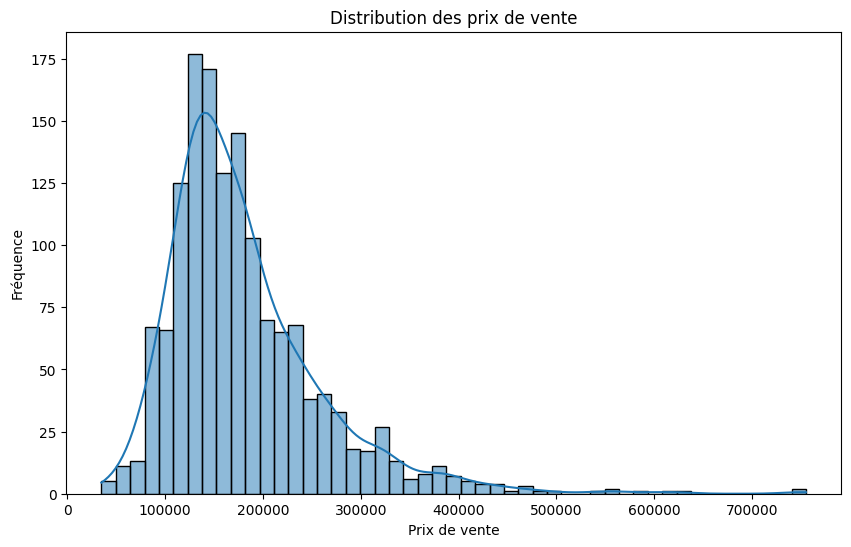

In [3]:
# Statistiques de base
print(train['SalePrice'].describe())

# Distribution de la variable cible : le prix du bien immobilier
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True)  #Ajoute une courbe de densité à l'histogramme
plt.title("Distribution des prix de vente")
plt.xlabel("Prix de vente")
plt.ylabel("Fréquence")
plt.show()

La maison la moins chère vaut donc 34900 dollars tandis que la plus chère est à 755000. La moyenne est d'environ 180921 dollars.

On va maintenant chercher à repérer les valeurs manquantes pour repérer les colonnes à traiter lors du nettoyage des données.

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


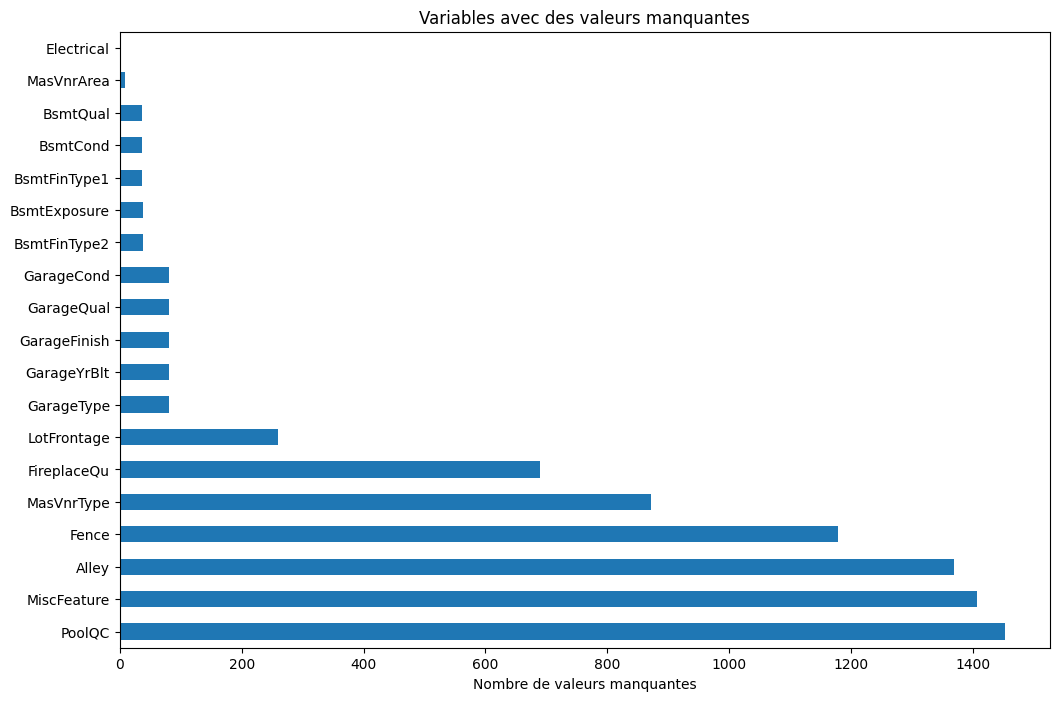

In [4]:
# Nombre de valeurs manquantes par variable
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False) #On ne garde que les variables avec des valeurs manquantes et on trie les variables qui ont des valeurs manquantes par ordre décroissant

print(missing)

# Affichage graphique des valeurs manquantes par variable
plt.figure(figsize=(12, 8))
missing.plot(kind="barh")    #bar chart horizontal
plt.title("Variables avec des valeurs manquantes")
plt.xlabel("Nombre de valeurs manquantes")
plt.show()

On va chercher à identifier les variables les plus influentes par rapport à la variable cible

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


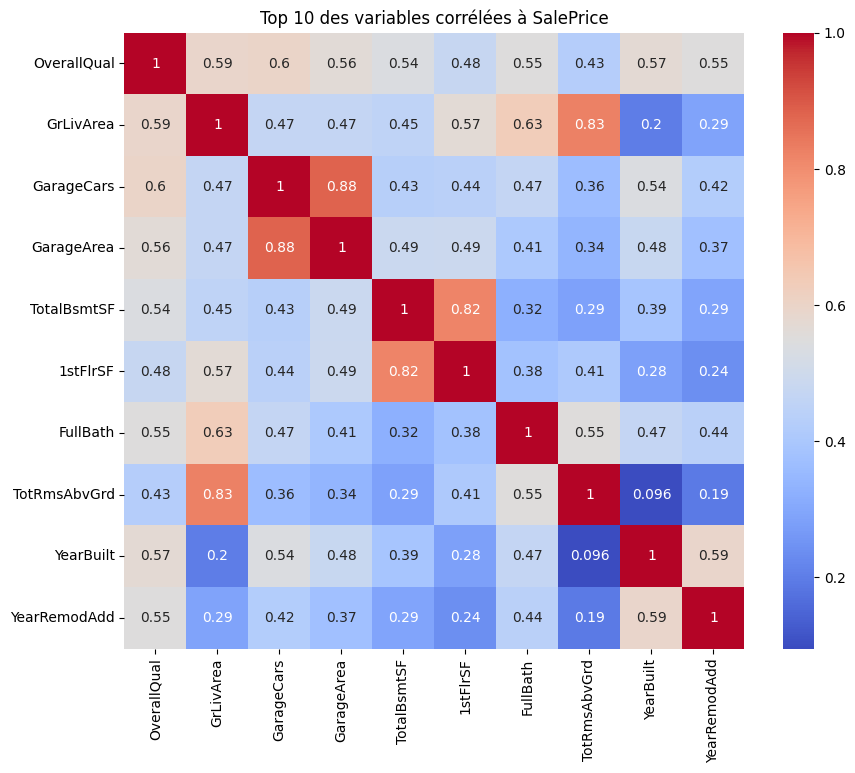

In [5]:
# Corrélation avec la variable cible
corr = train.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)
print(corr.head(10))  # Les plus fortes corrélations

# Heatmap des variables les plus corrélées
top_corr = corr[1:11].index  # Exclut SalePrice qui est la première variable

plt.figure(figsize=(10, 8))
sns.heatmap(train[top_corr].corr(), annot=True, cmap="coolwarm")
plt.title("Top 10 des variables corrélées à SalePrice")
plt.show()

Analysons ensuite la répartition des prix selon quelques variables clés, à savoir la surface habitable, la qualité globale et le quartier:

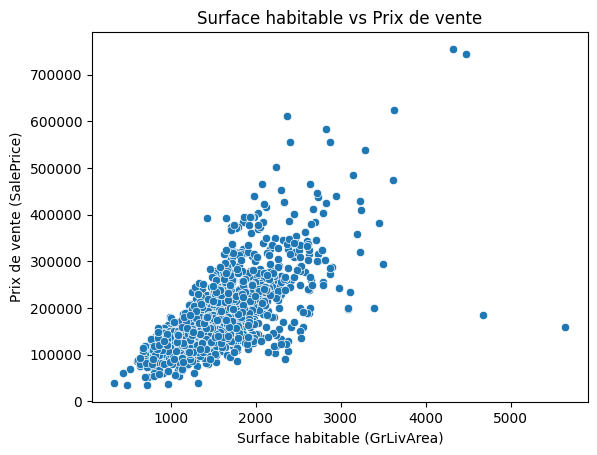

In [6]:
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.title("Surface habitable vs Prix de vente")
plt.xlabel("Surface habitable (GrLivArea)")
plt.ylabel("Prix de vente (SalePrice)")
plt.show()

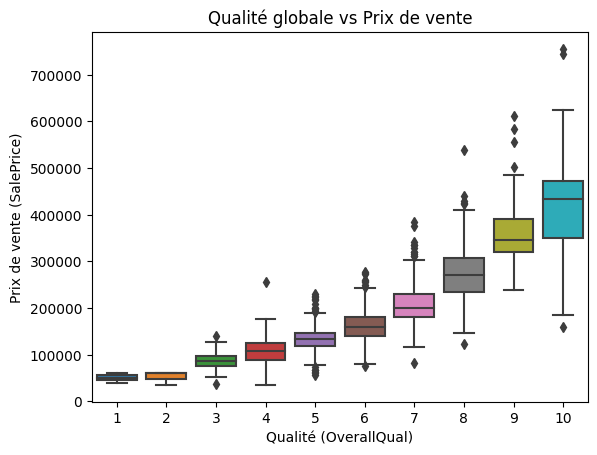

In [7]:
sns.boxplot(x=train['OverallQual'], y=train['SalePrice'])
plt.title("Qualité globale vs Prix de vente")
plt.xlabel("Qualité (OverallQual)")
plt.ylabel("Prix de vente (SalePrice)")
plt.show()

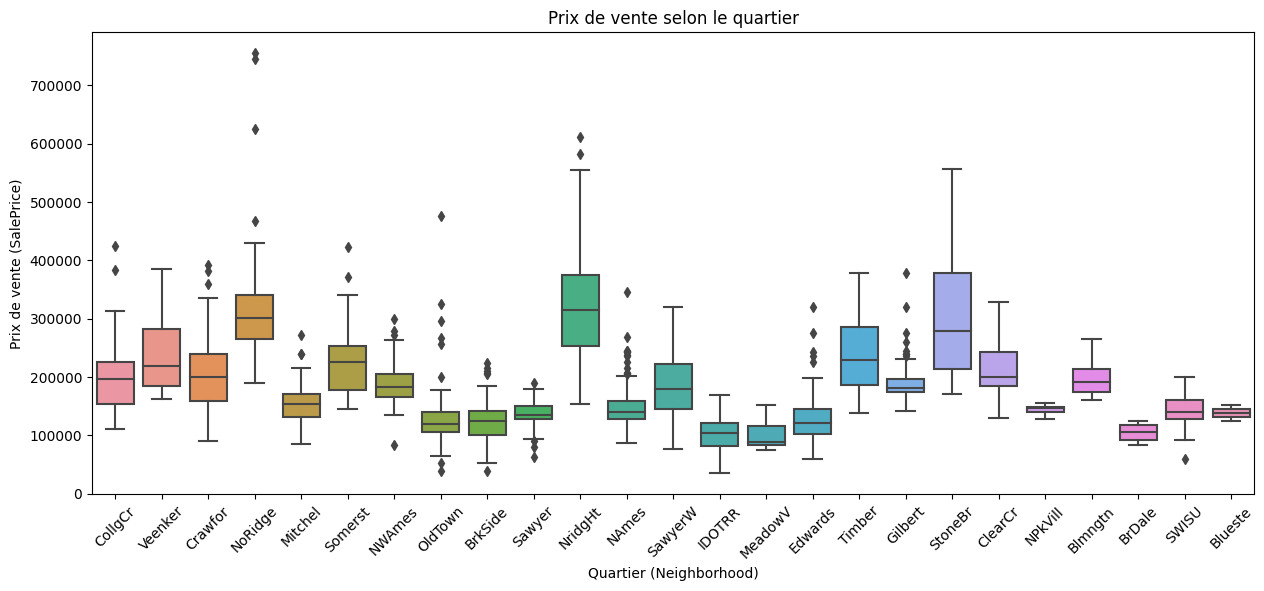

In [8]:
plt.figure(figsize=(15, 6))
sns.boxplot(x="Neighborhood", y="SalePrice", data=train)
plt.xticks(rotation=45)
plt.title("Prix de vente selon le quartier")
plt.xlabel("Quartier (Neighborhood)")
plt.ylabel("Prix de vente (SalePrice)")
plt.show()

# Nettoyage et préparation des données

Avant d'entraîner nos modèles, on va effectuer un nettoyage des données. Cette étape permet d'assurer la qualité des données utilisées, d'éviter les erreurs pendant l'entraînement, et d'améliorer la performance globale du modèle.

- **Séparation des features (`X`) et de la target (`y`)** :
  La variable à prédire ici est `SalePrice`, c’est donc notre cible (`y`), tandis que le reste des colonnes constitue nos variables explicatives (`X`).

- **Suppression des colonnes avec trop de valeurs manquantes** :  
  Certaines colonnes contiennent un pourcentage très élevé de valeurs manquantes (plus de 85%). Ces colonnes sont peu informatives ou difficiles à récupérer, et peuvent dégrader les performances du modèle si elles sont mal imputées.

- **Imputation des valeurs manquantes restantes** :
  - Pour les **variables numériques**, nous utilisons la **médiane**, plus robuste aux outliers que la moyenne.
  - Pour les **variables catégorielles**, nous utilisons une valeur fictive (`"None"`).

- **Concaténation des jeux de données `train` et `test` (optionnel)** :
  Cela permet d'appliquer le même traitement à toutes les données (encodage, nettoyage), puis de les séparer ensuite.

- **Encodage des variables catégorielles** :
  On va avoir besoin de données numériques pour notre premier modèle. Les variables catégorielles vont donc être encodées en  **one-hot** encoding


In [9]:
# 1. Séparation de la cible
y = train["SalePrice"]
train = train.drop("SalePrice", axis=1)  # Supprime la colonne SalePrice pour ne garder que les features

# 2. Suppression des colonnes avec trop de valeurs manquantes
threshold = 0.15  # 15 % de valeurs manquantes
missing_ratio = train.isnull().mean() # Ratio de valeurs manquantes pour chaque colonne
cols_to_drop = missing_ratio[missing_ratio > threshold].index  # Colonnes où le ratio de valeurs manquantes est supérieur au seuil

train.drop(cols_to_drop, axis=1, inplace=True) 
test.drop(cols_to_drop, axis=1, inplace=True)

# 3. Imputation des colonnes catégorielles (valeurs manquantes remplacées par "None")
for col in train.select_dtypes(include="object").columns:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")

# 4. Imputation des colonnes numériques (valeurs manquantes remplacées par la médiane)
num_cols = train.select_dtypes(include=["int64", "float64"]).columns
num_cols = [col for col in num_cols if col in test.columns]  # Parcourt les colonnes de train et ne garde que celles qui sont aussi dans test

for col in num_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())

# 5. Encodage des variables catégorielles (One-Hot Encoding)
all_data = pd.concat([train, test], keys=["train", "test"])
all_data = pd.get_dummies(all_data)

# 6. Re-séparation des datasets
train = all_data.xs("train")
test = all_data.xs("test")

# Régression linéaire

Dans un premier temps, on va essayer une **régression linéaire**, un modèle simple, rapide à entraîner, et très interprétable.

C'est intéressant dans le sens où c'est facile à interpréter (chaque coefficient représente l'effet d'une variable sur le prix) et ça peut mettre en lumière des problèmes de prétraitement des données.

Il y a néanmoins des limites car ça **suppose une relation linéaire** entre les variables et la cible (`SalePrice`), ce qui est rarement vrai dans les données immobilières réelles.
C'est aussi un modèle sensible aux **outliers** et il nécessite des variables **scalées**.

Ce modèle sert donc principalement de point de départ. Les performances qu’il atteint (souvent moyennes) vont servir de repère pour évaluer l’intérêt de modèles plus avancés (Random Forest, XGBoost...).


La régression linéaire donne un bon RMSE mais essayons un autre modèle tout de même.

RMSE du modèle de régression linéaire : 29674.95


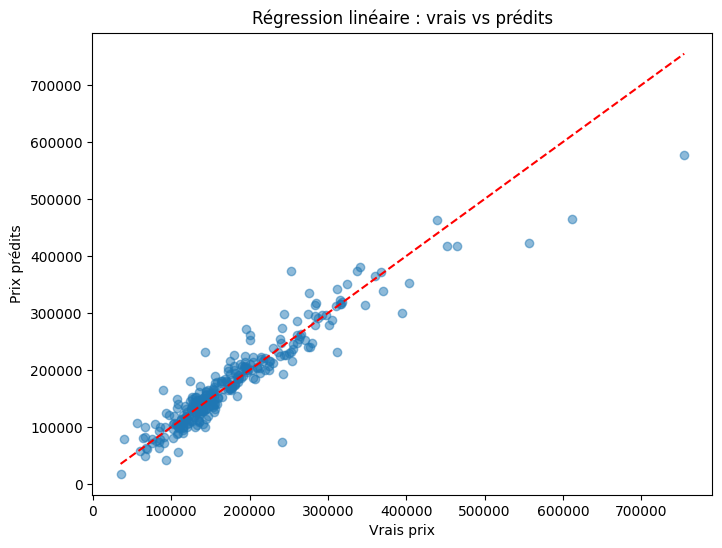

In [10]:
# 1. Séparation en train/validation (80% / 20%)
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)

# 2. Création et entraînement du modèle
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 3. Prédictions sur l’ensemble de validation
y_pred_lr = lr_model.predict(X_val)

# 4. Calcul du RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_lr))
print(f"RMSE du modèle de régression linéaire : {rmse:.2f}")

# 5. Visualisation des résidus
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_lr, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.xlabel("Vrais prix")
plt.ylabel("Prix prédits")
plt.title("Régression linéaire : vrais vs prédits")
plt.show()

# Random Forest

Après avoir testé une régression linéaire comme modèle de base, nous passons maintenant à un modèle plus puissant : la **Random Forest**.

C'est un modèle particulièrement adapté aux problèmes de régression complexes comme celui-ci (prédiction de prix immobiliers), car :
- Il **capte les relations non linéaires** entre les variables,
- Il est **robuste aux outliers** et au **bruit** dans les données,
- Il gère naturellement les **interactions entre variables**,
- Il nécessite peu de prétraitement (pas besoin de scaling des variables, par exemple).

Il va servir à comparer les performances avec la régression linéaire,

RMSE du modèle Random Forest : 29305.19


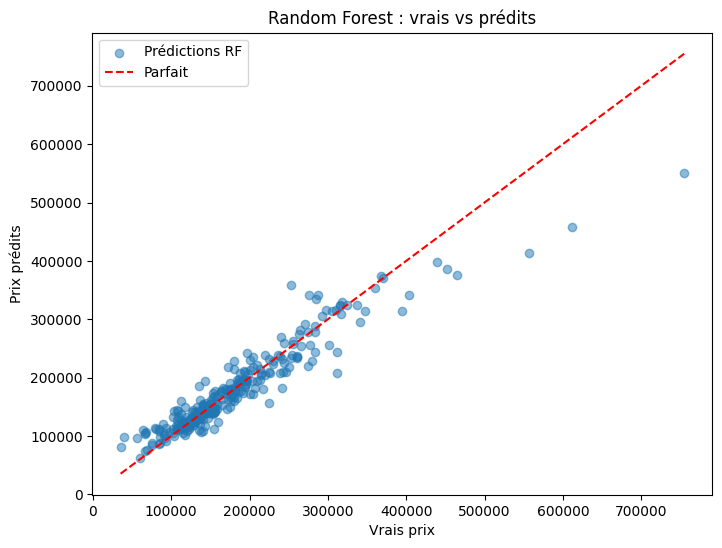

In [11]:
# Pas besoin de données standardisées pour Random Forest
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction sur l’ensemble de validation
y_pred_rf = rf_model.predict(X_val)

# Calcul du RMSE
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
print(f"RMSE du modèle Random Forest : {rmse_rf:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_rf, alpha=0.5, label='Prédictions RF')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='Parfait')
plt.xlabel("Vrais prix")
plt.ylabel("Prix prédits")
plt.title("Random Forest : vrais vs prédits")
plt.legend()
plt.show()

Le RMSE est légèrement plus bas (amélioration de 0,2%).

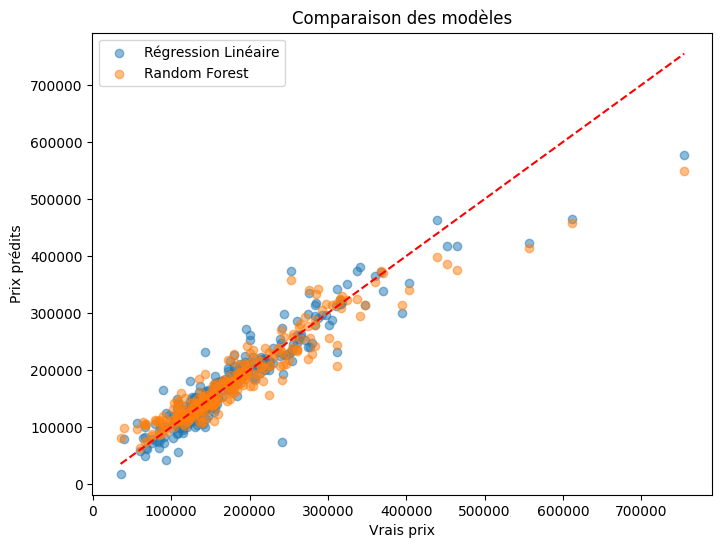

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_lr, alpha=0.5, label="Régression Linéaire")
plt.scatter(y_val, y_pred_rf, alpha=0.5, label="Random Forest")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.xlabel("Vrais prix")
plt.ylabel("Prix prédits")
plt.title("Comparaison des modèles")
plt.legend()
plt.show()

# Pipeline Scikit-learn

Après avoir testé une régression linéaire et une Random Forest simple, on va structurer l'approche avec un **pipeline Scikit-learn complet**.

Cela va **standardiser le processus** d'entraînement, avec un enchaînement clair des étapes : 
- traitement des valeurs manquantes
- encodage des variables catégorielles 
- scaling (si nécessaire) 
- modélisation

On va pouvoir prévenir toute forme de **data leakage**, en encapsulant le prétraitement **dans la cross-validation** et faciliter l’**optimisation des hyperparamètres** via `GridSearchCV`, afin d'obtenir les meilleurs réglages possibles pour notre modèle.

Cela permettra également d'améliorer la **reproductibilité et la robustesse** du modèle, tout en respectant les bonnes pratiques professionnelles en machine learning.

---

Cette approche pipeline + GridSearch permet d’**industrialiser** notre solution, ce qui est particulièrement important dans un cadre réel.

In [13]:
# Séparation train/validation
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=42)

# Colonnes numériques et catégorielles
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# Prétraitement numérique
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Prétraitement catégoriel
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine les transformations
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# Pipeline final
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Grille de recherche d’hyperparamètres
param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [None, 10, 20],
    "regressor__min_samples_split": [2, 5]
}

# Grid Search avec validation croisée 5-fold
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs hyperparamètres :")
print(grid_search.best_params_)

# Évaluation sur les données de validation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE sur le jeu de validation : {rmse:.2f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs hyperparamètres :
{'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
RMSE sur le jeu de validation : 29247.43


In [14]:
importances = best_model.named_steps["regressor"].feature_importances_
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
important_features = sorted(zip(importances, feature_names), reverse=True)[:10]

for score, name in important_features:
    print(f"{name}: {score:.4f}")


num__OverallQual: 0.5633
num__GrLivArea: 0.1258
num__TotalBsmtSF: 0.0375
num__2ndFlrSF: 0.0369
num__BsmtFinSF1: 0.0335
num__1stFlrSF: 0.0310
num__LotArea: 0.0216
num__GarageArea: 0.0192
num__YearBuilt: 0.0178
num__GarageCars: 0.0138


Les variables les plus influentes pour le prix sont OverallQual, GrLiveArea et TotalBsmtSF.

# Bilan et prolongements possibles du projet :
- Les données immobilières sont en partie linéaires pour les variables principales (surface, qualité, nombre de pièces, etc.) donc Random Forest n'a pas un gain énorme.
- La régression linéaire est déjà performante et interprétable.

- Pourquoi pas tester d'autres modèles avancés (XGBoost, LightGBM, ...)
- Intégration d’une visualisation interactive ou d’une API de prédiction